# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [18]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy import stats
from scipy.signal import hilbert
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the IMFs of the observations

In [8]:
%%time

os.chdir(wrkdir + "/data/")
imfs_sst_ds = xr.open_dataset("imfs_sst_CEEMDAN.nc")
imfs_mld_ds = xr.open_dataset("imfs_mld_CEEMDAN.nc")
imfs_z20_ds = xr.open_dataset("imfs_z20_CEEMDAN.nc")
imfs_oxy_ds = xr.open_dataset("imfs_oxy_CEEMDAN.nc")
#imfs_oxycline_ds = xr.open_dataset("imfs_oxycline.nc")
#imfs_p50_critz_ds = xr.open_dataset("imfs_p50_critz.nc")
#imfs_pO2_m_p50_z50_ds = xr.open_dataset("imfs_pO2_m_p50_z50.nc")
#imfs_pO2_m_p50_z100_ds = xr.open_dataset("imfs_pO2_m_p50_z100.nc")
#imfs_pO2_m_p50_z150_ds = xr.open_dataset("imfs_pO2_m_p50_z150.nc")
#imfs_pO2_m_p50_z200_ds = xr.open_dataset("imfs_pO2_m_p50_z200.nc")
#imfs_pO2_m_p50_z250_ds = xr.open_dataset("imfs_pO2_m_p50_z250.nc")
#imfs_pO2_m_p50_z300_ds = xr.open_dataset("imfs_pO2_m_p50_z300.nc")
imfs_chl_ds = xr.open_dataset("imfs_chl_CEEMDAN.nc")

imfs_sst_ds

CPU times: user 92.6 ms, sys: 13.2 ms, total: 106 ms
Wall time: 103 ms


<xarray.Dataset> Size: 718MB
Dimensions:    (IMF: 4, time: 240, lat: 173, lon: 360)
Coordinates:
    depth      (time) float32 960B ...
  * time       (time) datetime64[ns] 2kB 2005-01-16T12:00:00 ... 2024-12-16T1...
    month      (time) int64 2kB ...
  * IMF        (IMF) int64 32B 1 2 3 4
  * lat        (lat) float32 692B -83.0 -82.0 -81.0 -80.0 ... 87.0 88.0 89.0
  * lon        (lon) float32 1kB 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
Data variables:
    sst_imfs   (IMF, time, lat, lon) float64 478MB ...
    sst_anom   (time, lat, lon) float64 120MB ...
    sst_detr   (time, lat, lon) float64 120MB ...
    sst_trend  (lat, lon) float64 498kB ...

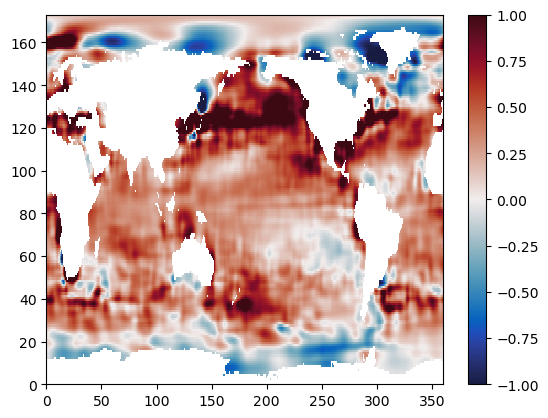

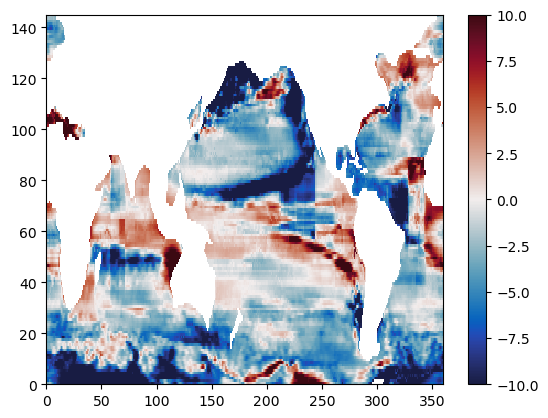

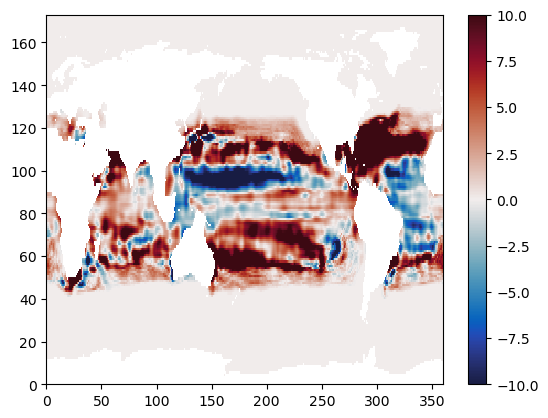

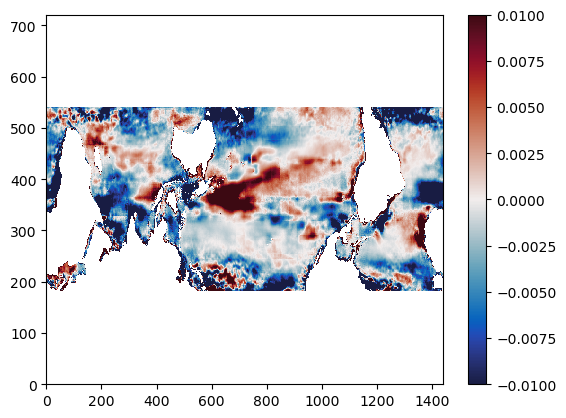

In [9]:
plt.figure()
plt.pcolormesh(imfs_sst_ds['sst_trend'], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_oxy_ds['oxy_trend'], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_z20_ds['z20_trend'], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_chl_ds['chl_trend'], cmap=cmo.balance, vmin=-1e-2, vmax=1e-2)
plt.colorbar()

## Load ENSO and IPO indices

### Regular IPO index

In [10]:
dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


/jobfs/142229825.gadi-pbs/ipykernel_558600/3220979946.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


### Tripolar IPO index

### ENSO index

<timed exec>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


CPU times: user 223 ms, sys: 11.1 ms, total: 234 ms
Wall time: 278 ms


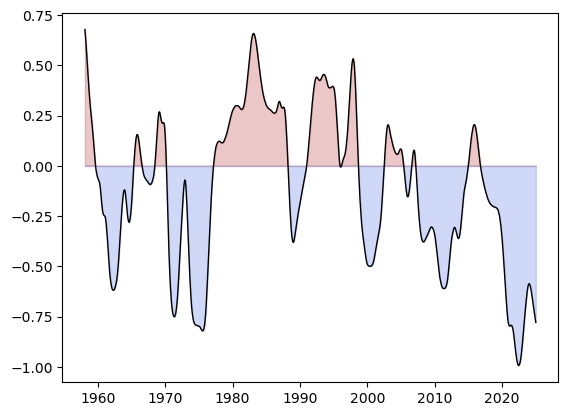

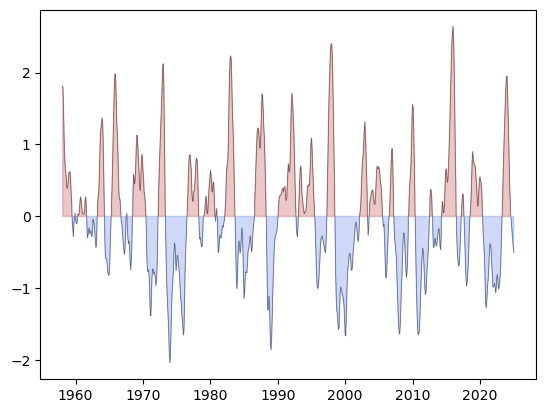

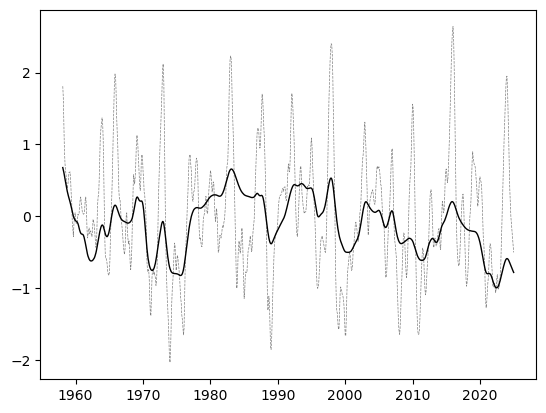

In [11]:
%%time


### Comes from "obs_derive_IPO.ipynb"
my_ipo = xr.open_dataset(wrkdir + "/data/derived_IPO.nc")['IPO']
my_ipo_pos = my_ipo.where(my_ipo > 0.0, other=0.0)
my_ipo_neg = my_ipo.where(my_ipo < 0.0, other=0.0)

'''
https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
'''
enso_index = pd.read_csv(wrkdir + "/data/ONI.txt", delimiter=', ')
enso_subset = enso_index[(enso_index['YR']>1957) & (enso_index['YR']<2025)]
enso = pd.DataFrame(
    {"time": dates,
     "index": enso_subset.drop(columns=['SEAS','YR']).squeeze(),
    }
)
enso['pos'] = enso['index'][enso['index']>0.0]
enso['neg'] = enso['index'][enso['index']<0.0]

plt.figure()
plt.plot(my_ipo.coords['time'], my_ipo, 'k-', alpha=1.0, linewidth=1.0)
plt.fill_between(my_ipo.coords['time'], 0, my_ipo_pos, color='firebrick', alpha=0.25)
plt.fill_between(my_ipo.coords['time'], 0, my_ipo_neg, color='royalblue', alpha=0.25)

plt.figure()
plt.plot(enso['time'], enso['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(enso['time'], 0, enso['pos'], color='firebrick', alpha=0.25)
plt.fill_between(enso['time'], 0, enso['neg'], color='royalblue', alpha=0.25)

plt.figure()
plt.plot(my_ipo.coords['time'], my_ipo, 'k-', alpha=1.0, linewidth=1.0)
plt.plot(enso['time'], enso['index'], 'k--', alpha=0.5, linewidth=0.5)


## Correlation analysis against ENSO and IPO indices

In [14]:
print(np.shape(imfs_sst_ds['sst_imfs']))
print(np.shape(imfs_mld_ds['mld_imfs']))
print(np.shape(imfs_z20_ds['z20_imfs']))
print(np.shape(imfs_oxy_ds['oxy_imfs']))
print(np.shape(imfs_chl_ds['chl_imfs']))


(4, 240, 173, 360)
(4, 240, 173, 360)
(4, 240, 173, 360)
(4, 240, 145, 360)
(4, 276, 721, 1440)


In [15]:
%%time

enso_sst_ccoef = np.zeros((2,173,360))
ipo_sst_ccoef = np.zeros((2,173,360))

enso_z20_ccoef = np.zeros((2,173,360))
ipo_z20_ccoef = np.zeros((2,173,360))

enso_mld_ccoef = np.zeros((2,173,360))
ipo_mld_ccoef = np.zeros((2,173,360))

enso_oxy_ccoef = np.zeros((2,145,360))
ipo_oxy_ccoef = np.zeros((2,145,360))

enso_chl_ccoef = np.zeros((2,721,1440))
ipo_chl_ccoef = np.zeros((2,721,1440))


enso_sst_slope = np.zeros((5,173,360))
ipo_sst_slope = np.zeros((5,173,360))

enso_z20_slope = np.zeros((5,173,360))
ipo_z20_slope = np.zeros((5,173,360))

enso_mld_slope = np.zeros((5,173,360))
ipo_mld_slope = np.zeros((5,173,360))

enso_oxy_slope = np.zeros((5,145,360))
ipo_oxy_slope = np.zeros((5,145,360))

enso_chl_slope = np.zeros((5,721,1440))
ipo_chl_slope = np.zeros((5,721,1440))


sst_imfs = imfs_sst_ds['sst_imfs']
z20_imfs = imfs_z20_ds['z20_imfs']
mld_imfs = imfs_mld_ds['mld_imfs']
oxy_imfs = imfs_oxy_ds['oxy_imfs']
chl_imfs = imfs_chl_ds['chl_imfs']


CPU times: user 24.2 ms, sys: 1.9 ms, total: 26.1 ms
Wall time: 23.8 ms


In [16]:
print(sst_imfs.coords['time'].max())
print(my_ipo.coords['time'].max())
#ipo[ipo['time'].dt.year > 2004][-13::]
#ipo[ipo['time'].dt.year > 2004]['time'][0:-12]
#sst_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31"))
#enso[enso['time'].dt.year > 2003]['time'][0:-12]


<xarray.DataArray 'time' ()> Size: 8B
array('2024-12-16T12:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()> Size: 8B
array('2024-12-31T00:00:00.000000000', dtype='datetime64[ns]')


[0.01999257 0.75797783]
[6.18334429e-01 1.04350764e-26]


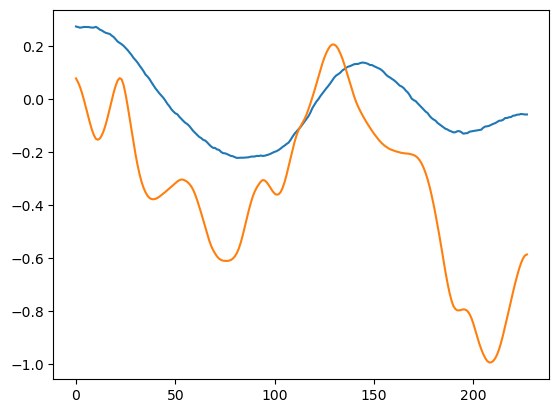

In [19]:
ix = 50; iy = 50

plt.figure()
plt.plot(sst_imfs.isel(IMF=2,lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31")))
plt.plot(my_ipo.sel(time=slice("2005-01-01","2023-12-31")))

enso_index = enso[enso['time'].dt.year > 2004]['index']
ipo_index = my_ipo.sel(time=slice("2005-01-01","2024-12-31")).values

sst_data = sst_imfs.isel(lon=ix, lat=iy)
imf1 = sst_data.isel(IMF=1)
imf2 = sst_data.isel(IMF=2)

print(np.array(stats.pearsonr(imf1, enso_index)[:]))
print(np.array(stats.pearsonr(imf2, ipo_index)[:]))



In [20]:
%%time

from joblib import Parallel, delayed
import numpy as np
import scipy.stats as stats

# Pre-slice time indices
enso_index = enso[enso['time'].dt.year > 2004]['index']
ipo_index = my_ipo.sel(time=slice("2005-01-01","2024-12-31")).values

# Dimensions
nlat = len(sst_imfs.lat)
nlon = len(sst_imfs.lon)

# Output arrays (assuming shape [2, nlat, nlon])
enso_sst_ccoef = np.full((2, nlat, nlon), np.nan)
ipo_sst_ccoef = np.full((2, nlat, nlon), np.nan)
enso_sst_slope = np.full((5, nlat, nlon), np.nan)  # linregress returns 5-tuple
ipo_sst_slope = np.full((5, nlat, nlon), np.nan)

def process_cell(ix, iy):
    result = {}
    sst_data = sst_imfs.isel(lon=ix, lat=iy)
    valid = False
    if sst_data.notnull().all() and not (sst_data == 0.0).all():
        imf1 = sst_data.isel(IMF=1)
        imf2 = sst_data.isel(IMF=2)
        result['enso_sst_ccoef'] = np.array(stats.pearsonr(imf1, enso_index)[:])
        result['ipo_sst_ccoef'] = np.array(stats.pearsonr(imf2, ipo_index)[:])
        result['enso_sst_slope'] = np.array(stats.linregress(enso_index, imf1)[:])
        result['ipo_sst_slope'] = np.array(stats.linregress(ipo_index, imf2)[:])
        valid = True
    if valid:
            return (ix, iy, result)
    else:
        return None

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for ix in range(nlon) for iy in range(nlat)
)



[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   18.3s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   19.0s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   24.1s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   33.3s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   38.3s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   38.5s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   38.5s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   38.7s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   38.8s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   38.8s
[Parallel(n_jobs=56)]: Batch computation too fast (0.19467003133015054s.) Setting batch_size=2.
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   38.8s
[Parallel(n_jobs=56)]

CPU times: user 1min 4s, sys: 4.09 s, total: 1min 8s
Wall time: 1min 53s


[Parallel(n_jobs=56)]: Done 62280 out of 62280 | elapsed:  1.9min finished


CPU times: user 288 ms, sys: 36.3 ms, total: 325 ms
Wall time: 323 ms


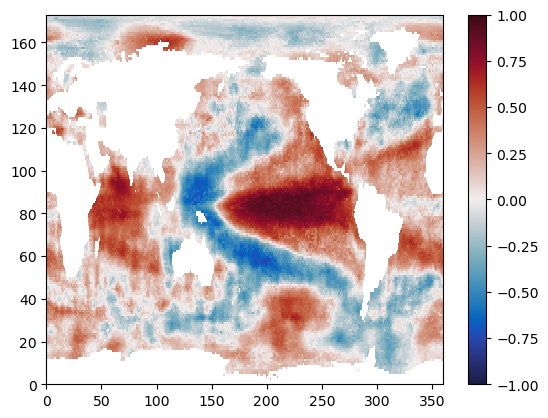

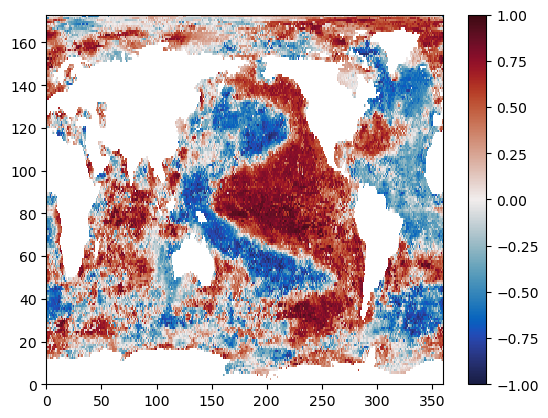

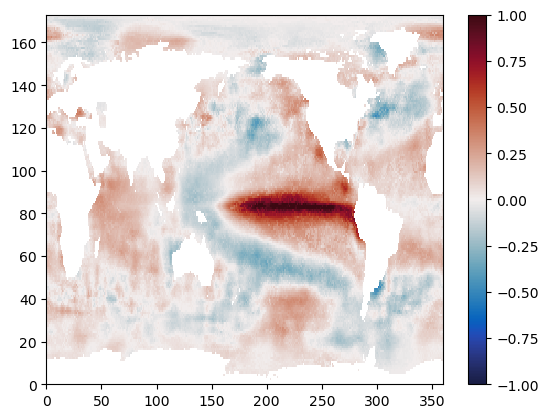

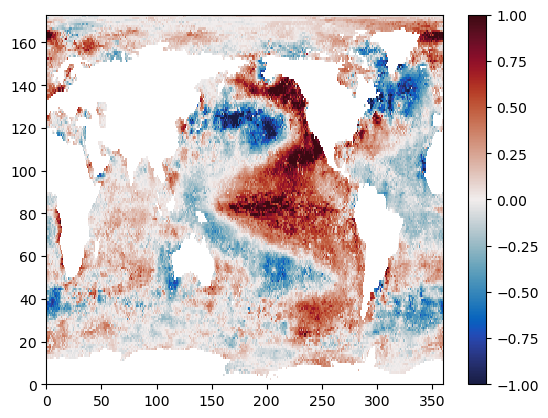

In [22]:
%%time

valid_results = [r for r in results if r is not None]

# Fill results into arrays
for ix, iy, res in valid_results:
    if 'enso_sst_ccoef' in res:
        enso_sst_ccoef[:, iy, ix] = res['enso_sst_ccoef']
        ipo_sst_ccoef[:, iy, ix] = res['ipo_sst_ccoef']
        enso_sst_slope[:, iy, ix] = res['enso_sst_slope']
        ipo_sst_slope[:, iy, ix] = res['ipo_sst_slope']

plt.figure()
plt.pcolormesh(enso_sst_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_sst_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_sst_slope[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_sst_slope[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()



In [23]:
%%time

sst_corr_ds = xr.Dataset(
    {
        "sst_corr_enso": (["coef_pval", "lat", "lon"], enso_sst_ccoef),
        "sst_corr_ipo": (["coef_pval", "lat", "lon"], ipo_sst_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

sst_effect_ds = xr.Dataset(
    {
        "sst_effect_enso": (["stats", "lat", "lon"], enso_sst_slope),
        "sst_effect_ipo": (["stats", "lat", "lon"], ipo_sst_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
os.remove("sst_corr_ENSO_IPO.nc")
os.remove("sst_effect_ENSO_IPO.nc")

sst_corr_ds.to_netcdf("sst_corr_ENSO_IPO.nc")
sst_effect_ds.to_netcdf("sst_effect_ENSO_IPO.nc")



CPU times: user 362 ms, sys: 200 ms, total: 562 ms
Wall time: 5.83 s


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   11.4s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:   14.0s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   15.2s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:   16.6s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   18.4s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   20.5s
[Parallel(n_jobs=56)]: Done 3088 tasks      | elapsed:   23.0s
[Parallel(n_jobs=56)]: Done 3938 tasks      | elapsed:   25.7s
[Parallel(n_jobs=56)]: Done 4888 tasks      | elapsed:   28.7s
[Parallel(n_jobs=56)]: Done 5938 tasks      | elapsed:   32.1s
[Parallel(n_jobs=56)]: Done 7088 tasks      | elapsed:   35.8s
[Parallel(n_jobs=56)]: Done 8338 tasks      | elapsed:   39.9s
[Parallel(n_jobs=56)]: Done 9688 tasks      | elapsed:   44.4s
[Parallel(n_jobs=56)]: Done 11138 tasks      | elapsed:   49.2s
[Parallel(n_jobs=56)]: Done 12688 tasks    

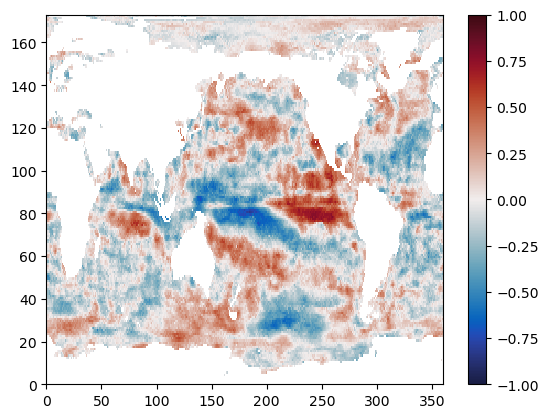

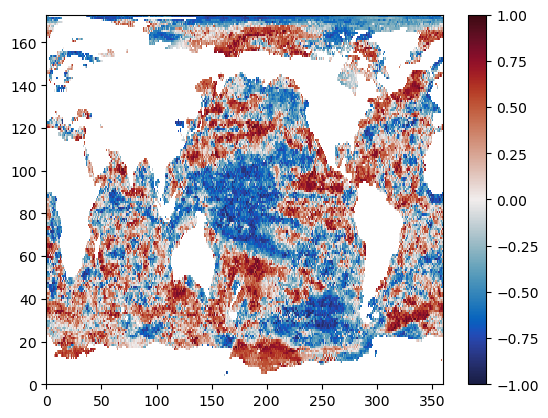

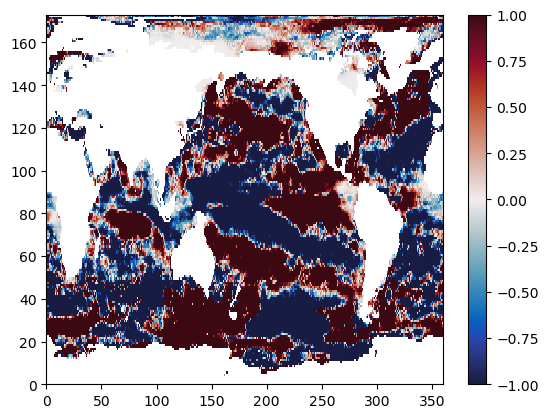

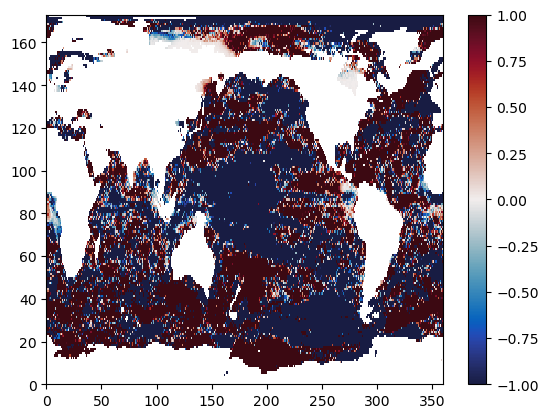

In [24]:
# Output arrays (assuming shape [2, nlat, nlon])
enso_mld_ccoef = np.full((2, nlat, nlon), np.nan)
ipo_mld_ccoef = np.full((2, nlat, nlon), np.nan)
enso_mld_slope = np.full((5, nlat, nlon), np.nan)  # linregress returns 5-tuple
ipo_mld_slope = np.full((5, nlat, nlon), np.nan)

def process_cell(ix, iy):
    result = {}
    mld_data = mld_imfs.isel(lon=ix, lat=iy)
    valid = False
    if mld_data.notnull().all() and not (mld_data == 0.0).all():
        imf1 = mld_data.isel(IMF=1)
        imf2 = mld_data.isel(IMF=2)
        result['enso_mld_ccoef'] = np.array(stats.pearsonr(imf1, enso_index)[:])
        result['ipo_mld_ccoef'] = np.array(stats.pearsonr(imf2, ipo_index)[:])
        result['enso_mld_slope'] = np.array(stats.linregress(enso_index, imf1)[:])
        result['ipo_mld_slope'] = np.array(stats.linregress(ipo_index, imf2)[:])
        valid = True
    if valid:
            return (ix, iy, result)
    else:
        return None

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for ix in range(nlon) for iy in range(nlat)
)


valid_results = [r for r in results if r is not None]

# Fill results into arrays
for ix, iy, res in valid_results:
    if 'enso_mld_ccoef' in res:
        enso_mld_ccoef[:, iy, ix] = res['enso_mld_ccoef']
        ipo_mld_ccoef[:, iy, ix] = res['ipo_mld_ccoef']
        enso_mld_slope[:, iy, ix] = res['enso_mld_slope']
        ipo_mld_slope[:, iy, ix] = res['ipo_mld_slope']

plt.figure()
plt.pcolormesh(enso_mld_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_mld_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_mld_slope[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_mld_slope[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()



In [25]:
%%time

mld_corr_ds = xr.Dataset(
    {
        "mld_corr_enso": (["coef_pval", "lat", "lon"], enso_mld_ccoef),
        "mld_corr_ipo": (["coef_pval", "lat", "lon"], ipo_mld_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)


mld_effect_ds = xr.Dataset(
    {
        "mld_effect_enso": (["stats", "lat", "lon"], enso_mld_slope),
        "mld_effect_ipo": (["stats", "lat", "lon"], ipo_mld_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
os.remove("mld_corr_ENSO_IPO.nc")
os.remove("mld_effect_ENSO_IPO.nc")

mld_corr_ds.to_netcdf("mld_corr_ENSO_IPO.nc")
mld_effect_ds.to_netcdf("mld_effect_ENSO_IPO.nc")



CPU times: user 31.5 ms, sys: 19.6 ms, total: 51.1 ms
Wall time: 129 ms


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   59.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:  1.2min
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:  1.3min
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:  1.3min
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:  1.3min
[Parallel(n_jobs=56)]: Done 3088 tasks      | elapsed:  1.4min
[Parallel(n_jobs=56)]: Done 3938 tasks      | elapsed:  1.4min
[Parallel(n_jobs=56)]: Done 4888 tasks      | elapsed:  1.5min
[Parallel(n_jobs=56)]: Done 5938 tasks      | elapsed:  1.5min
[Parallel(n_jobs=56)]: Done 7088 tasks      | elapsed:  1.6min
[Parallel(n_jobs=56)]: Done 8338 tasks      | elapsed:  1.7min
[Parallel(n_jobs=56)]: Done 9688 tasks      | elapsed:  1.8min
[Parallel(n_jobs=56)]: Done 11138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=56)]: Done 12688 tasks    

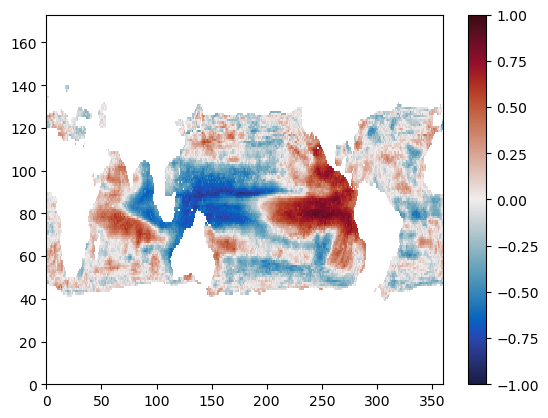

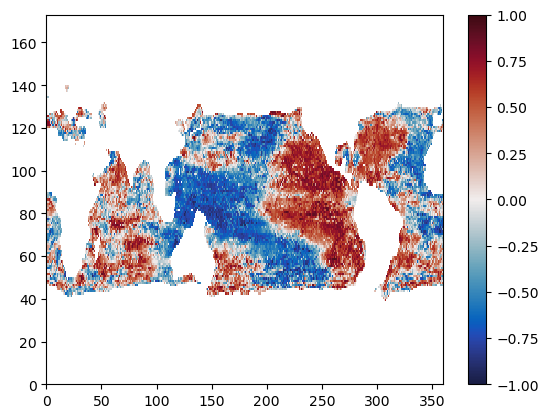

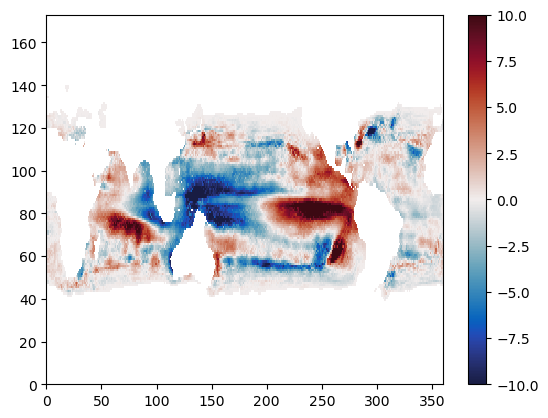

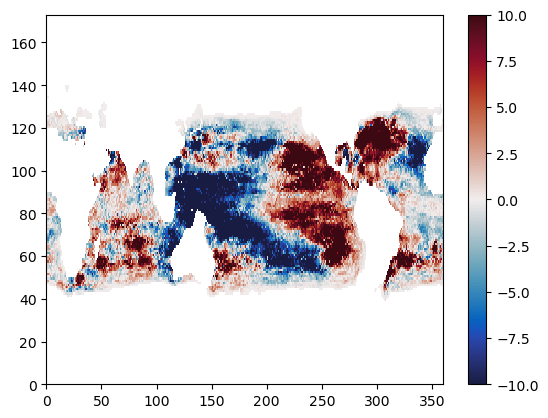

In [26]:
# Output arrays (assuming shape [2, nlat, nlon])
enso_z20_ccoef = np.full((2, nlat, nlon), np.nan)
ipo_z20_ccoef = np.full((2, nlat, nlon), np.nan)
enso_z20_slope = np.full((5, nlat, nlon), np.nan)  # linregress returns 5-tuple
ipo_z20_slope = np.full((5, nlat, nlon), np.nan)

def process_cell(ix, iy):
    result = {}
    z20_data = z20_imfs.isel(lon=ix, lat=iy)
    valid = False
    if z20_data.notnull().all() and not (z20_data == 0.0).all():
        imf1 = z20_data.isel(IMF=1)
        imf2 = z20_data.isel(IMF=2)
        result['enso_z20_ccoef'] = np.array(stats.pearsonr(imf1, enso_index)[:])
        result['ipo_z20_ccoef'] = np.array(stats.pearsonr(imf2, ipo_index)[:])
        result['enso_z20_slope'] = np.array(stats.linregress(enso_index, imf1)[:])
        result['ipo_z20_slope'] = np.array(stats.linregress(ipo_index, imf2)[:])
        valid = True
    if valid:
            return (ix, iy, result)
    else:
        return None

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for ix in range(nlon) for iy in range(nlat)
)


valid_results = [r for r in results if r is not None]

# Fill results into arrays
for ix, iy, res in valid_results:
    if 'enso_z20_ccoef' in res:
        enso_z20_ccoef[:, iy, ix] = res['enso_z20_ccoef']
        ipo_z20_ccoef[:, iy, ix] = res['ipo_z20_ccoef']
        enso_z20_slope[:, iy, ix] = res['enso_z20_slope']
        ipo_z20_slope[:, iy, ix] = res['ipo_z20_slope']

plt.figure()
plt.pcolormesh(enso_z20_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_z20_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_z20_slope[0,:,:], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_z20_slope[0,:,:], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()



In [28]:
%%time

z20_corr_ds = xr.Dataset(
    {
        "z20_corr_enso": (["coef_pval", "lat", "lon"], enso_z20_ccoef),
        "z20_corr_ipo": (["coef_pval", "lat", "lon"], ipo_z20_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": z20_imfs.coords['lat'].values,
        "lon": z20_imfs.coords['lon'].values,
    },
)


z20_effect_ds = xr.Dataset(
    {
        "z20_effect_enso": (["stats", "lat", "lon"], enso_z20_slope),
        "z20_effect_ipo": (["stats", "lat", "lon"], ipo_z20_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": z20_imfs.coords['lat'].values,
        "lon": z20_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
#os.remove("z20_corr_ENSO_IPO.nc")
#os.remove("z20_effect_ENSO_IPO.nc")

z20_corr_ds.to_netcdf("z20_corr_ENSO_IPO.nc")
z20_effect_ds.to_netcdf("z20_effect_ENSO_IPO.nc")



CPU times: user 25.5 ms, sys: 28.7 ms, total: 54.2 ms
Wall time: 190 ms


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   28.8s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:   30.1s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   31.4s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:   33.0s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   34.9s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   37.2s
[Parallel(n_jobs=56)]: Done 3088 tasks      | elapsed:   39.9s
[Parallel(n_jobs=56)]: Done 3938 tasks      | elapsed:   42.9s
[Parallel(n_jobs=56)]: Done 4888 tasks      | elapsed:   46.2s
[Parallel(n_jobs=56)]: Done 5938 tasks      | elapsed:   49.9s
[Parallel(n_jobs=56)]: Done 7088 tasks      | elapsed:   53.7s
[Parallel(n_jobs=56)]: Done 8338 tasks      | elapsed:   57.7s
[Parallel(n_jobs=56)]: Done 9688 tasks      | elapsed:  1.0min
[Parallel(n_jobs=56)]: Done 11138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=56)]: Done 12688 tasks    

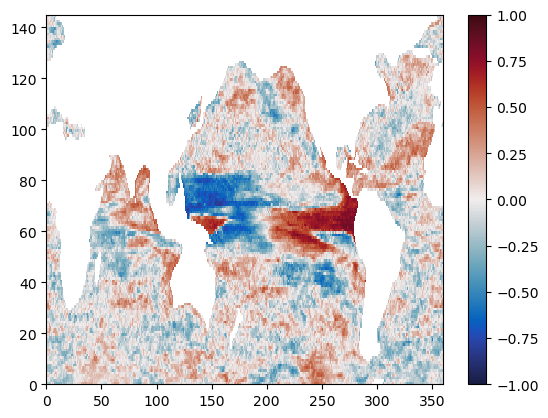

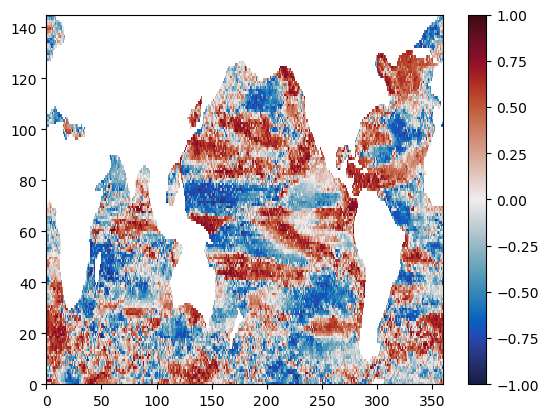

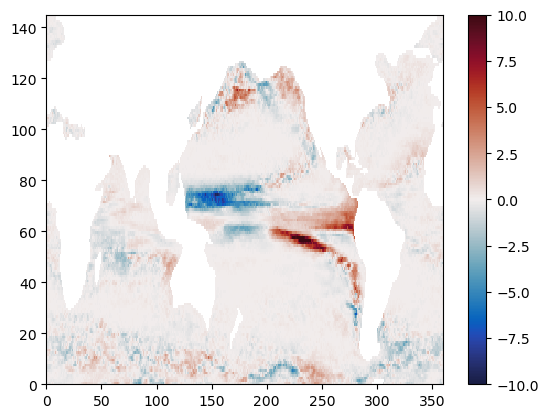

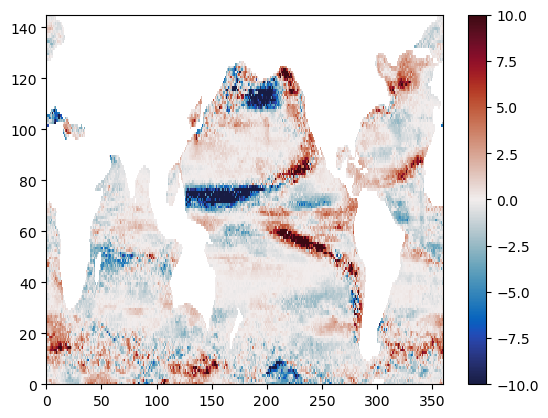

In [47]:

# Pre-slice time indices
enso_index = enso[enso['time'].dt.year > 2003]['index'][0:-12]
ipo_index = my_ipo.sel(time=slice("2004-01-01","2023-12-31")).values

# Dimensions
nlat = len(oxy_imfs.lat)
nlon = len(oxy_imfs.lon)

# Output arrays (assuming shape [2, nlat, nlon])
enso_oxy_ccoef = np.full((2, nlat, nlon), np.nan)
ipo_oxy_ccoef = np.full((2, nlat, nlon), np.nan)
enso_oxy_slope = np.full((5, nlat, nlon), np.nan)  # linregress returns 5-tuple
ipo_oxy_slope = np.full((5, nlat, nlon), np.nan)

def process_cell(ix, iy):
    result = {}
    oxy_data = oxy_imfs.isel(lon=ix, lat=iy)
    valid = False
    if oxy_data.notnull().all() and not (oxy_data == 0.0).all():
        imf1 = oxy_data.isel(IMF=1)
        imf2 = oxy_data.isel(IMF=2)
        result['enso_oxy_ccoef'] = np.array(stats.pearsonr(imf1, enso_index)[:])
        result['ipo_oxy_ccoef'] = np.array(stats.pearsonr(imf2, ipo_index)[:])
        result['enso_oxy_slope'] = np.array(stats.linregress(enso_index, imf1)[:])
        result['ipo_oxy_slope'] = np.array(stats.linregress(ipo_index, imf2)[:])
        valid = True
    if valid:
            return (ix, iy, result)
    else:
        return None

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for ix in range(nlon) for iy in range(nlat)
)


valid_results = [r for r in results if r is not None]

# Fill results into arrays
for ix, iy, res in valid_results:
    if 'enso_oxy_ccoef' in res:
        enso_oxy_ccoef[:, iy, ix] = res['enso_oxy_ccoef']
        ipo_oxy_ccoef[:, iy, ix] = res['ipo_oxy_ccoef']
        enso_oxy_slope[:, iy, ix] = res['enso_oxy_slope']
        ipo_oxy_slope[:, iy, ix] = res['ipo_oxy_slope']

plt.figure()
plt.pcolormesh(enso_oxy_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_oxy_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_oxy_slope[0,:,:], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_oxy_slope[0,:,:], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()



In [49]:
%%time

oxy_corr_ds = xr.Dataset(
    {
        "oxy_corr_enso": (["coef_pval", "lat", "lon"], enso_oxy_ccoef),
        "oxy_corr_ipo": (["coef_pval", "lat", "lon"], ipo_oxy_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": oxy_imfs.coords['lat'].values,
        "lon": oxy_imfs.coords['lon'].values,
    },
)


oxy_effect_ds = xr.Dataset(
    {
        "oxy_effect_enso": (["stats", "lat", "lon"], enso_oxy_slope),
        "oxy_effect_ipo": (["stats", "lat", "lon"], ipo_oxy_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": oxy_imfs.coords['lat'].values,
        "lon": oxy_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
os.remove("oxy_corr_ENSO_IPO.nc")
os.remove("oxy_effect_ENSO_IPO.nc")

oxy_corr_ds.to_netcdf("oxy_corr_ENSO_IPO.nc")
oxy_effect_ds.to_netcdf("oxy_effect_ENSO_IPO.nc")



CPU times: user 33.3 ms, sys: 12.7 ms, total: 46 ms
Wall time: 178 ms


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:  7.1min
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed: 17.9min
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed: 31.6min
[Parallel(n_jobs=56)]: Done 1314 tasks      | elapsed: 31.7min
[Parallel(n_jobs=56)]: Done 1950 tasks      | elapsed: 32.1min
[Parallel(n_jobs=56)]: Done 2612 tasks      | elapsed: 32.1min
[Parallel(n_jobs=56)]: Done 3368 tasks      | elapsed: 32.2min
[Parallel(n_jobs=56)]: Done 4218 tasks      | elapsed: 32.2min
[Parallel(n_jobs=56)]: Done 5168 tasks      | elapsed: 32.3min
[Parallel(n_jobs=56)]: Done 6218 tasks      | elapsed: 32.3min
[Parallel(n_jobs=56)]: Done 7368 tasks      | elapsed: 32.4min
[Parallel(n_jobs=56)]: Done 8618 tasks      | elapsed: 32.5min
[Parallel(n_jobs=56)]: Done 9968 tasks      | elapsed: 32.5min
[Parallel(n_jobs=56)]: Done 11418 tasks      | elapsed: 32.6min
[Parallel(n_jobs=56)]: Done 12968 tasks    

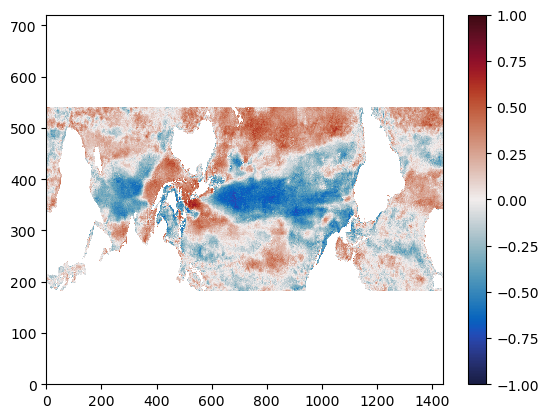

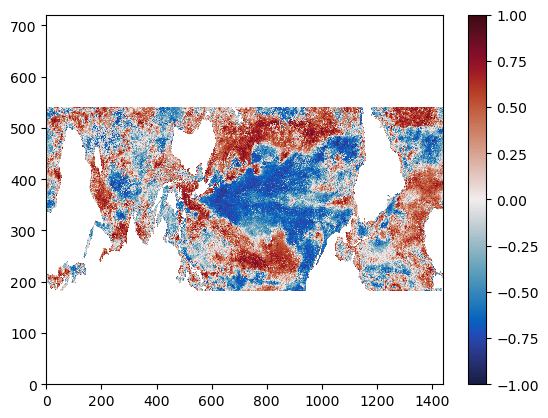

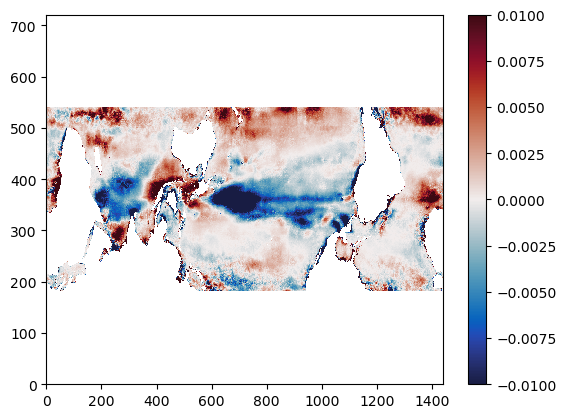

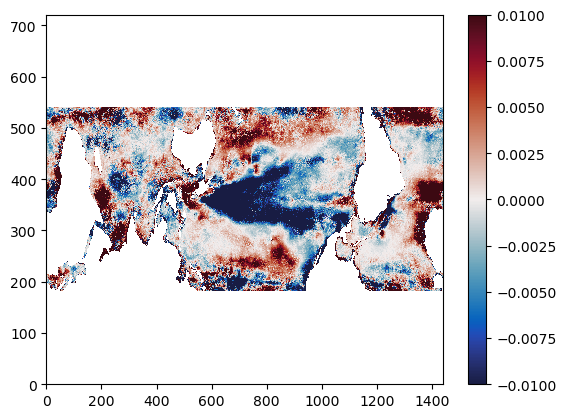

In [51]:

# Pre-slice time indices
enso_index = enso[enso['time'].dt.year > 2000]['index'][0:-12]
ipo_index = my_ipo.sel(time=slice("2001-01-01","2023-12-31")).values

# Dimensions
nlat = len(chl_imfs.lat)
nlon = len(chl_imfs.lon)

# Output arrays (assuming shape [2, nlat, nlon])
enso_chl_ccoef = np.full((2, nlat, nlon), np.nan)
ipo_chl_ccoef = np.full((2, nlat, nlon), np.nan)
enso_chl_slope = np.full((5, nlat, nlon), np.nan)  # linregress returns 5-tuple
ipo_chl_slope = np.full((5, nlat, nlon), np.nan)

def process_cell(ix, iy):
    result = {}
    chl_data = chl_imfs.isel(lon=ix, lat=iy)
    valid = False
    if chl_data.notnull().all() and not (chl_data == 0.0).all():
        imf1 = chl_data.isel(IMF=1)
        imf2 = chl_data.isel(IMF=2)
        result['enso_chl_ccoef'] = np.array(stats.pearsonr(imf1, enso_index)[:])
        result['ipo_chl_ccoef'] = np.array(stats.pearsonr(imf2, ipo_index)[:])
        result['enso_chl_slope'] = np.array(stats.linregress(enso_index, imf1)[:])
        result['ipo_chl_slope'] = np.array(stats.linregress(ipo_index, imf2)[:])
        valid = True
    if valid:
            return (ix, iy, result)
    else:
        return None

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for ix in range(nlon) for iy in range(nlat)
)

valid_results = [r for r in results if r is not None]

# Fill results into arrays
for ix, iy, res in valid_results:
    if 'enso_chl_ccoef' in res:
        enso_chl_ccoef[:, iy, ix] = res['enso_chl_ccoef']
        ipo_chl_ccoef[:, iy, ix] = res['ipo_chl_ccoef']
        enso_chl_slope[:, iy, ix] = res['enso_chl_slope']
        ipo_chl_slope[:, iy, ix] = res['ipo_chl_slope']

plt.figure()
plt.pcolormesh(enso_chl_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_chl_ccoef[0,:,:], cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_chl_slope[0,:,:], cmap=cmo.balance, vmin=-1e-2, vmax=1e-2)
plt.colorbar()

plt.figure()
plt.pcolormesh(ipo_chl_slope[0,:,:], cmap=cmo.balance, vmin=-1e-2, vmax=1e-2)
plt.colorbar()



In [53]:
%%time

chl_corr_ds = xr.Dataset(
    {
        "chl_corr_enso": (["coef_pval", "lat", "lon"], enso_chl_ccoef),
        "chl_corr_ipo": (["coef_pval", "lat", "lon"], ipo_chl_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)


chl_effect_ds = xr.Dataset(
    {
        "chl_effect_enso": (["stats", "lat", "lon"], enso_chl_slope),
        "chl_effect_ipo": (["stats", "lat", "lon"], ipo_chl_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
os.remove("chl_corr_ENSO_IPO.nc")
os.remove("chl_effect_ENSO_IPO.nc")

chl_corr_ds.to_netcdf("chl_corr_ENSO_IPO.nc")
chl_effect_ds.to_netcdf("chl_effect_ENSO_IPO.nc")



CPU times: user 29.8 ms, sys: 152 ms, total: 182 ms
Wall time: 424 ms


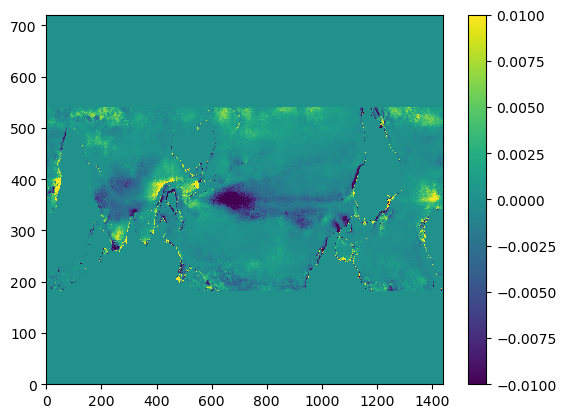

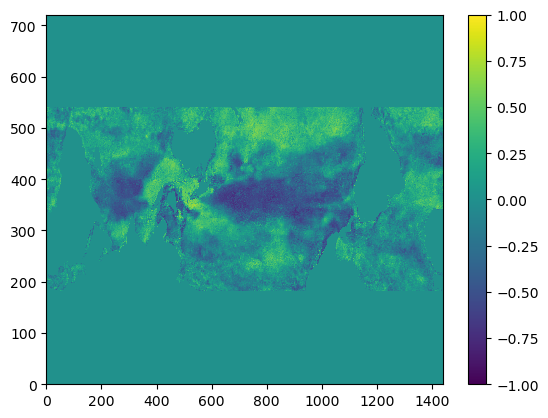

In [22]:
np.shape(ipo_chl_slope)
plt.figure()
plt.pcolormesh(enso_chl_slope[0,:,:], vmin=-0.01, vmax=0.01)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_chl_ccoef[0,:,:], vmin=-1, vmax=1)
plt.colorbar()



In [25]:
%%time

chl_corr_ds = xr.Dataset(
    {
        "chl_corr_enso": (["coef_pval", "lat", "lon"], enso_chl_ccoef),
        "chl_corr_ipo": (["coef_pval", "lat", "lon"], ipo_chl_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)

chl_effect_ds = xr.Dataset(
    {
        "chl_effect_enso": (["stats", "lat", "lon"], enso_chl_slope),
        "chl_effect_ipo": (["stats", "lat", "lon"], ipo_chl_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)



os.chdir(wrkdir + "/data")
os.remove("chl_corr_ENSO_IPO.nc")
os.remove("chl_effect_ENSO_IPO.nc")

chl_corr_ds.to_netcdf("chl_corr_ENSO_IPO.nc")
chl_effect_ds.to_netcdf("chl_effect_ENSO_IPO.nc")


/g/data/es60/pjb581/SPC/data
CPU times: user 38.4 ms, sys: 153 ms, total: 192 ms
Wall time: 322 ms


## Load the above (precooked)

In [58]:
os.chdir(wrkdir + "/data")

enso_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_enso"]
ipo_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_ipo"]
enso_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_enso"]
ipo_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_ipo"]

enso_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_enso"]
ipo_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_ipo"]
enso_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_enso"]
ipo_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_ipo"]

enso_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_enso"]
ipo_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_ipo"]
enso_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_enso"]
ipo_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_ipo"]

enso_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_enso"]
ipo_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_ipo"]
enso_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_enso"]
ipo_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_ipo"]

enso_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_enso"]
ipo_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_ipo"]
enso_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_enso"]
ipo_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_ipo"]

enso_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_enso"]
ipo_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_ipo"]
enso_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_enso"]
ipo_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_ipo"]

enso_p50_critz_ccoef

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/es60/pjb581/SPC/data/chl_corr_ENSO_IPO.nc'

## Visualise the correlations

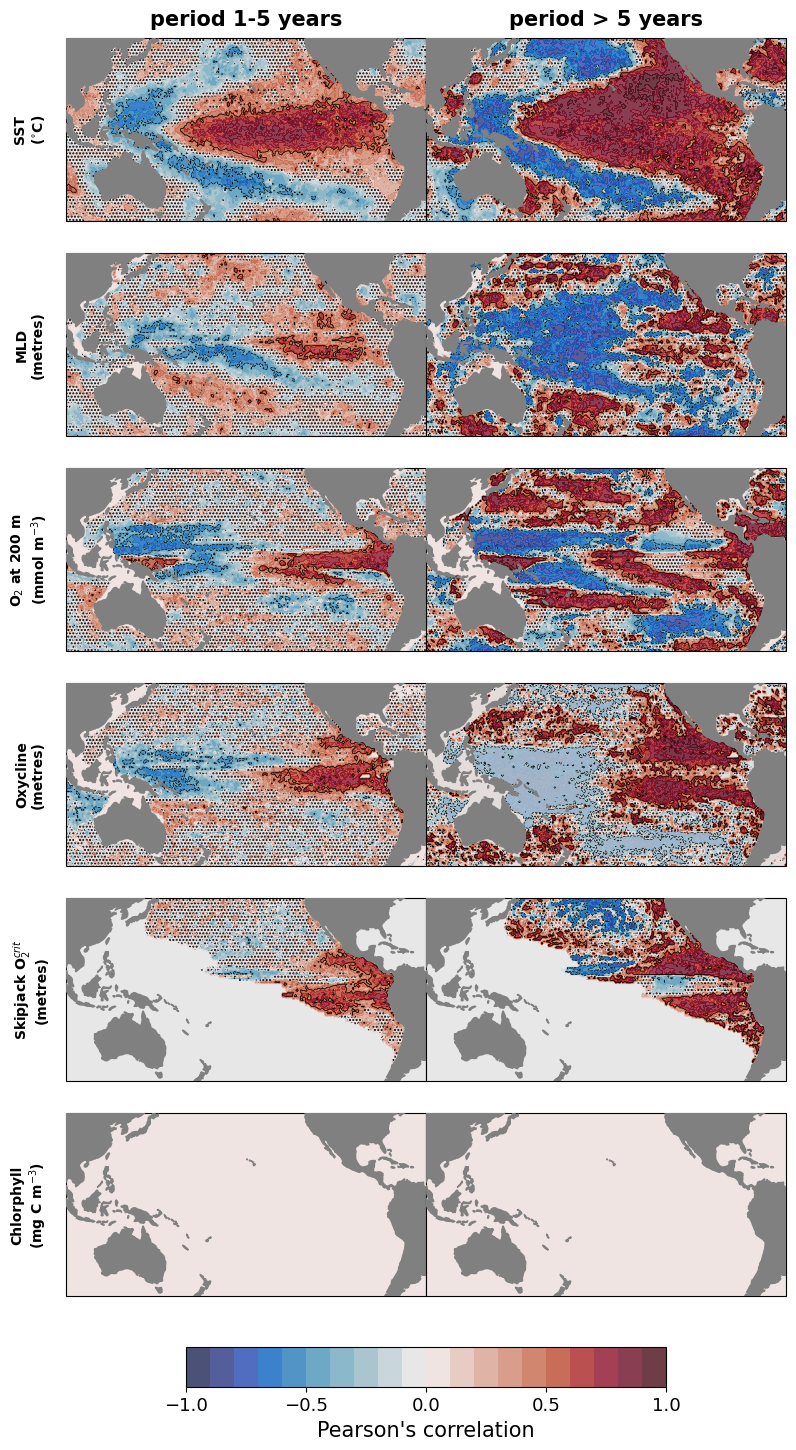

In [56]:

lon_sst = sst_imfs.coords['lon'].values
lat_sst = sst_imfs.coords['lat'].values
lon_oxy = oxy200m_imfs.coords['lon'].values
lat_oxy = oxy200m_imfs.coords['lat'].values
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-1,1.1,0.1)
contlevs = [-0.5, 0.5]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(8,16))
gs = GridSpec(6, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)
ax9 = plt.subplot(gs[4,0], projection=proj)
ax10 = plt.subplot(gs[4,1], projection=proj)
ax11 = plt.subplot(gs[5,0], projection=proj)
ax12 = plt.subplot(gs[5,1], projection=proj)

p1 = ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, enso_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p3 = ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax3.contour(lon_sst, lat_sst, enso_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p4 = ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax4.contour(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax5.contour(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p6 = ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax6.contour(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p7 = ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax7.contour(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax8.contour(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p9 = ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax9.contour(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p10 = ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax10.contour(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax11.contour(lon_chl, lat_chl, enso_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p12 = ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax12.contour(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)

plt.subplots_adjust(top=0.95, right=0.975, left=0.075, wspace=0.0, hspace=0.05, bottom=0.15)

cbax = fig.add_axes([0.225, 0.1, 0.6, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("Pearson's correlation", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'MLD\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax3.transAxes)
plt.text(xx, yy, 'O$_2$ at 200 m\n(mmol m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax5.transAxes)
plt.text(xx, yy, 'Oxycline\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Skipjack O$^{crit}_2$\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax9.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax11.transAxes)

ax1.text(0.5, 1.1, 'period 1-5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'period > 5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 100; lon2 = 300
lat1 = -45; lat2 = 45
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax3.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax6.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax9.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax12.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())



In [ ]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific.png", dpi=300)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific_transparent.png", dpi=300, transparent=True)
